# Installing libraries

In [1]:
import sys
import subprocess
import pkg_resources

libraries = [
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'joblib',
]

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for lib in libraries:
    try:
        dist = pkg_resources.get_distribution(lib)
        print(f"{lib} is already installed (version {dist.version})")
    except pkg_resources.DistributionNotFound:
        print(f"{lib} is not installed. Installing...")
        install(lib)


pandas is already installed (version 1.4.4)
numpy is already installed (version 1.24.4)
scikit-learn is already installed (version 1.0.2)
matplotlib is already installed (version 3.5.2)
seaborn is already installed (version 0.11.2)
joblib is already installed (version 1.4.2)


# 0. Add libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Final_Code

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error (MAE): 2.1077629571132626
Mean Squared Error (MSE): 11.533570996122448
R^2 Score: 0.6466036781510818
Explained Variance Score: 0.646730546383143
دیتاست خروجی شامل پیش‌بینی‌ها در فایل اکسل ذخیره شد.


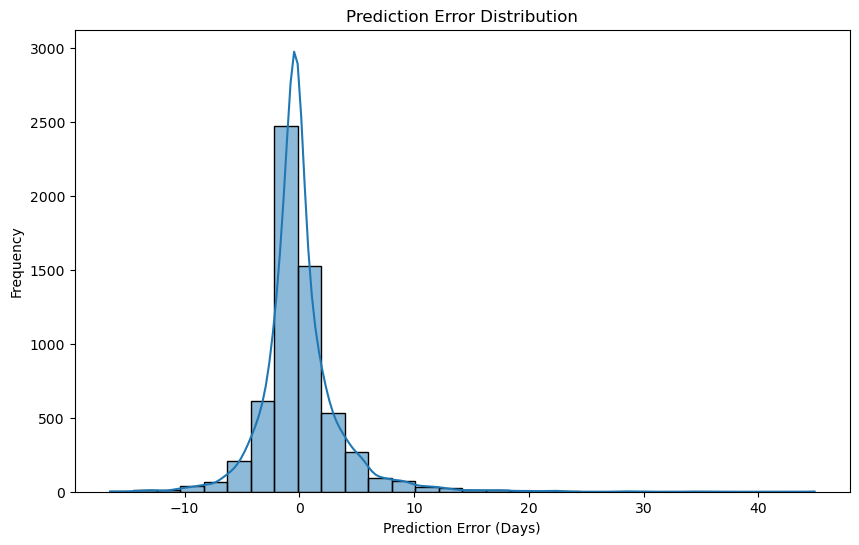

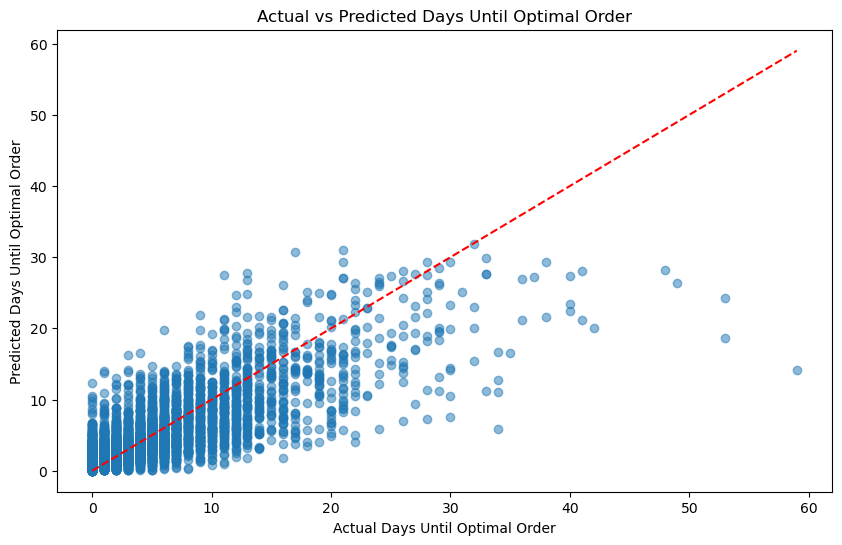

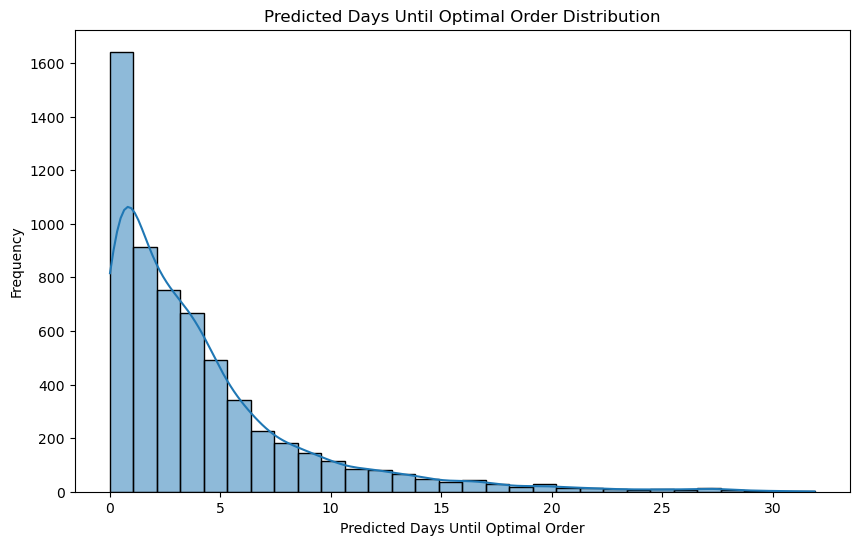

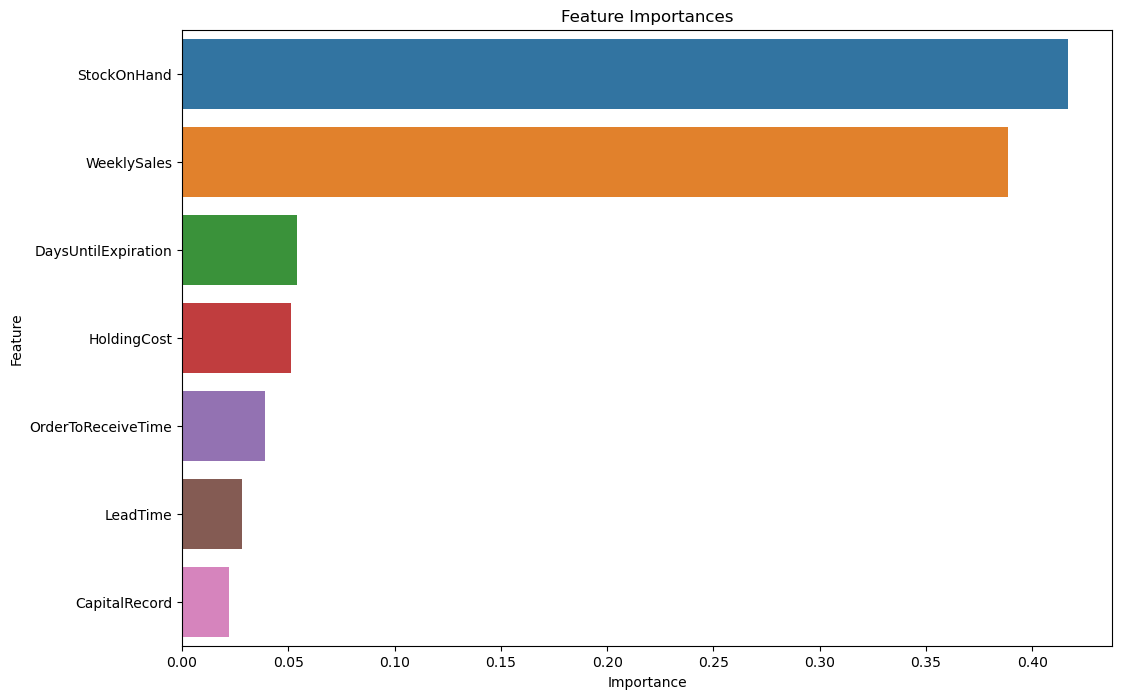

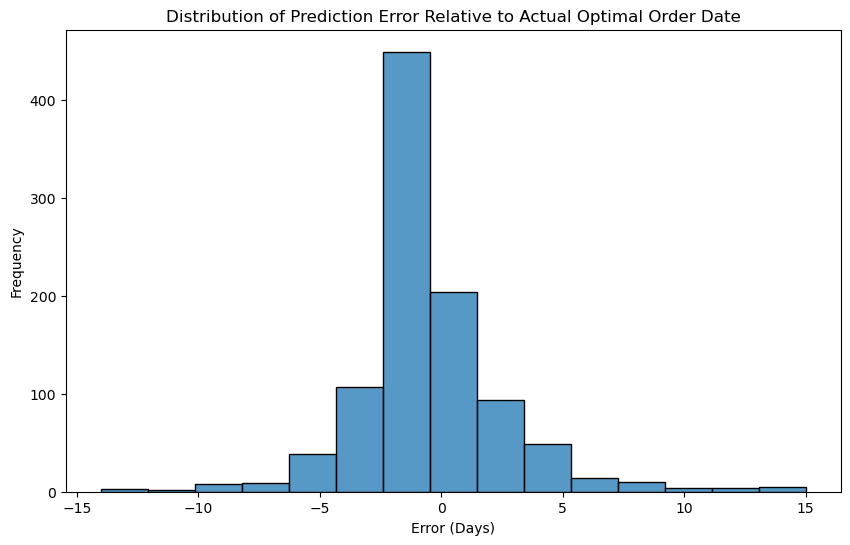

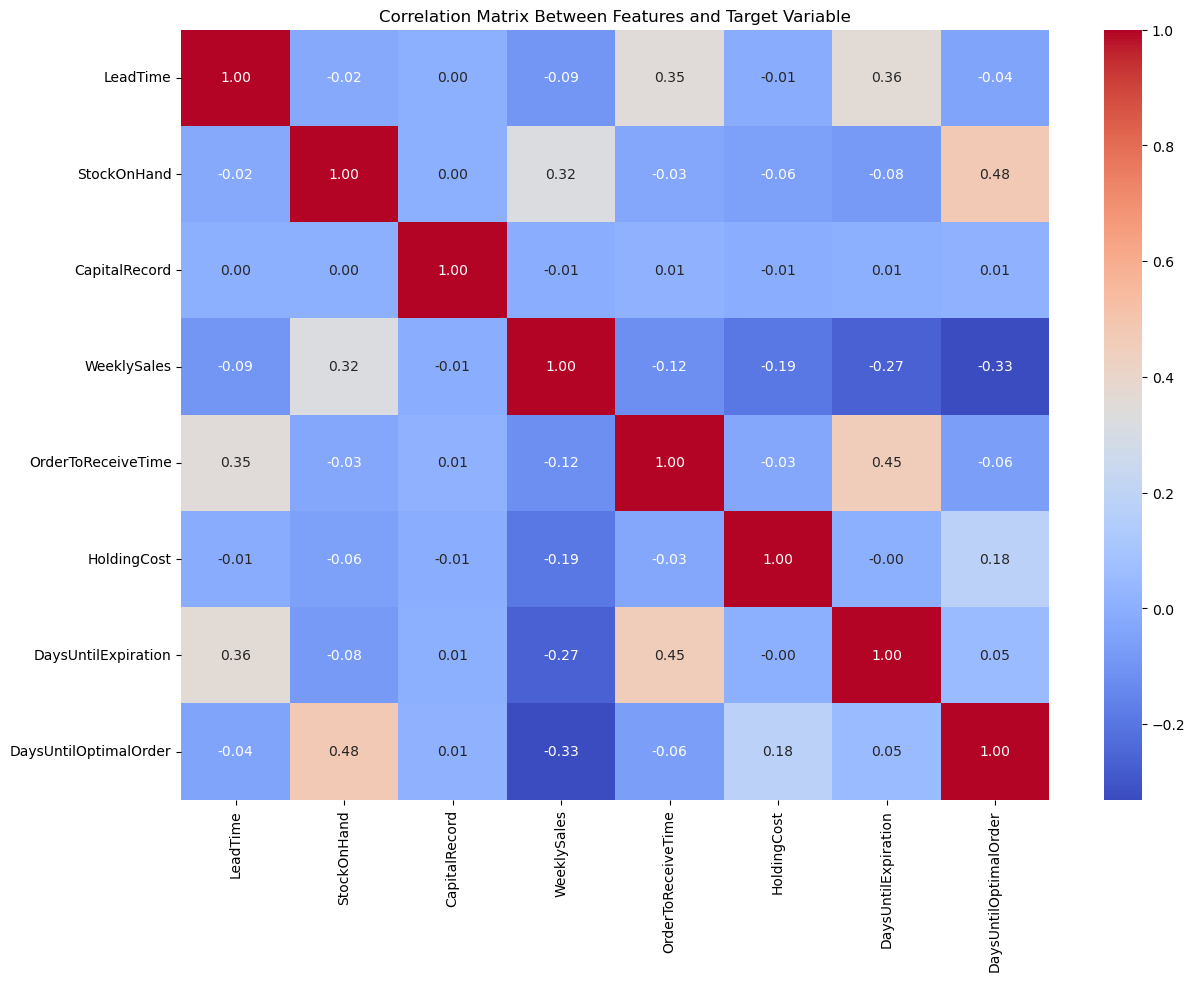

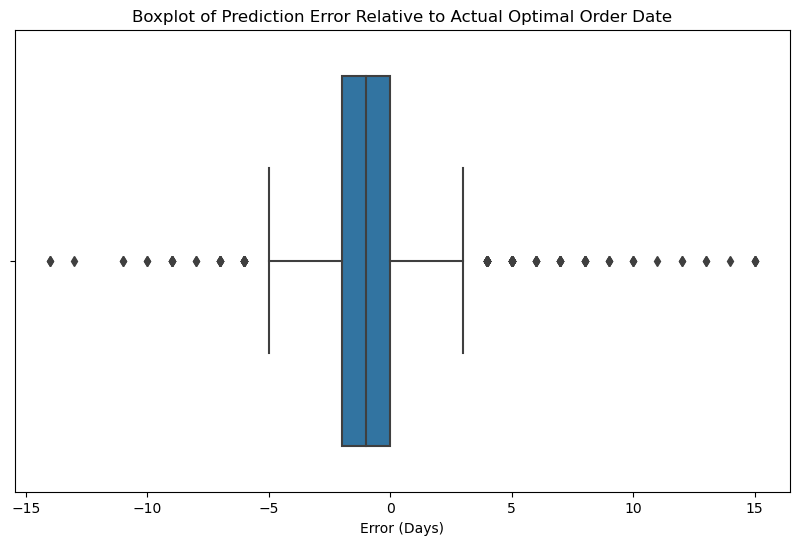

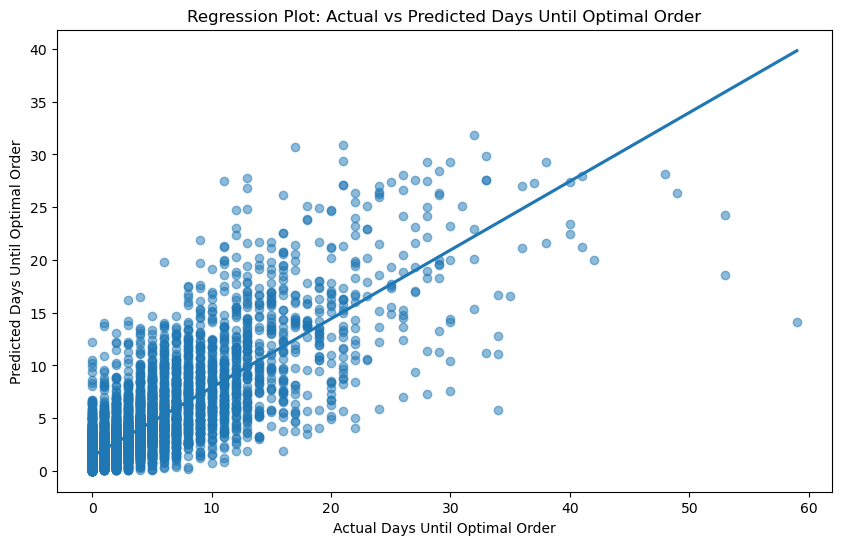

In [3]:
# بارگذاری دیتاست
df = pd.read_csv('inventory_dataset_noisy_v3.csv')

# تبدیل ستون‌های OrderDate و OptimalOrderDate به نوع datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')
df['OptimalOrderDate'] = pd.to_datetime(df['OptimalOrderDate'], errors='coerce')

# محاسبه تعداد روزها تا تاریخ بهینه سفارش (متغیر هدف)
df['DaysUntilOptimalOrder'] = (df['OptimalOrderDate'] - df['OrderDate']).dt.days

# تعریف ویژگی‌ها و متغیر هدف
features = ['LeadTime', 'StockOnHand', 'CapitalRecord', 'WeeklySales', 
            'OrderToReceiveTime', 'HoldingCost', 'DaysUntilExpiration']

X = pd.get_dummies(df[features], drop_first=True)
y = df['DaysUntilOptimalOrder']

# تقسیم داده‌ها به مجموعه‌های آموزشی و آزمون (70% آموزش، 30% آزمون)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ایجاد و آموزش مدل با تنظیم‌های هایپرتوپیک
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# نمایش بهترین تنظیم‌های هایپرتوپیک
print(f"Best Parameters: {grid_search.best_params_}")
model = grid_search.best_estimator_

# پیش‌بینی تعداد روزها برای مجموعه آزمون
y_pred = model.predict(X_test)

# ارزیابی مدل
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")
print(f"Explained Variance Score: {explained_var}")

# ذخیره مدل
joblib.dump(model, 'final_model.pkl')

# پیش‌بینی تعداد روزها برای کل مجموعه آزمون
test_df = df.iloc[y_test.index].copy()  # استفاده از copy() برای اطمینان از تغییر در نسخه اصلی
test_df.loc[:, 'PredictedDaysUntilOptimalOrder'] = y_pred
test_df.loc[:, 'PredictedOptimalOrderDate'] = test_df['OrderDate'] + pd.to_timedelta(test_df['PredictedDaysUntilOptimalOrder'], unit='D')

# ذخیره‌سازی دیتاست خروجی شامل پیش‌بینی‌ها در یک فایل اکسل
output_df = test_df[['OrderID', 'OrderDate', 'OptimalOrderDate', 'PredictedOptimalOrderDate']]
output_df.to_excel('inventory_predictions_output_test_noisy_v3.xlsx', index=False)
print("دیتاست خروجی شامل پیش‌بینی‌ها در فایل اکسل ذخیره شد.")

# نمودارهای اضافی

# 1. نمودار خطای پیش‌بینی
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Days)')
plt.ylabel('Frequency')
plt.show()

# 2. نمودار واقعی در مقابل پیش‌بینی‌شده
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Days Until Optimal Order')
plt.ylabel('Predicted Days Until Optimal Order')
plt.title('Actual vs Predicted Days Until Optimal Order')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()

# 3. نمودار توزیع مقادیر پیش‌بینی‌شده
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True)
plt.title('Predicted Days Until Optimal Order Distribution')
plt.xlabel('Predicted Days Until Optimal Order')
plt.ylabel('Frequency')
plt.show()

# 4. نمودار مهم‌ترین ویژگی‌ها
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# 5. نمونه کوچکتر برای نمودار خطای پیش‌بینی نسبت به تاریخ بهینه واقعی
small_sample = test_df.sample(n=1000, random_state=42)
small_sample['DateError'] = (small_sample['OptimalOrderDate'] - small_sample['PredictedOptimalOrderDate']).dt.days
small_sample['DateError'] = small_sample['DateError'].clip(lower=-15, upper=15)  # محدود کردن اختلاف روزها برای جلوگیری از مشکلات حافظه
plt.figure(figsize=(10, 6))
sns.histplot(small_sample['DateError'], bins=15, kde=False)
plt.title('Distribution of Prediction Error Relative to Actual Optimal Order Date')
plt.xlabel('Error (Days)')
plt.ylabel('Frequency')
plt.show()

# 6. نمودار بررسی همبستگی بین ویژگی‌ها و متغیر هدف
plt.figure(figsize=(14, 10))
corr_matrix = df[features + ['DaysUntilOptimalOrder']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Between Features and Target Variable')
plt.show()

# 7. نمودار تجزیه و تحلیل باکس پلات خطاها
plt.figure(figsize=(10, 6))
sns.boxplot(data=small_sample, x='DateError')
plt.title('Boxplot of Prediction Error Relative to Actual Optimal Order Date')
plt.xlabel('Error (Days)')
plt.show()

# 8. نمودار رگرسیون پیش‌بینی در مقابل مقدار واقعی
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws={'alpha':0.5})
plt.xlabel('Actual Days Until Optimal Order')
plt.ylabel('Predicted Days Until Optimal Order')
plt.title('Regression Plot: Actual vs Predicted Days Until Optimal Order')
plt.show()
